# Mentoria Data Science Academy

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk import word_tokenize 
from nltk.collocations import BigramCollocationFinder
import os
import pickle

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# Downloads do pacote NLTK
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\joaop\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## 0.0 Carregando os Dados

In [3]:
data_path = 'dados'
df1 = pd.read_csv(os.path.join(data_path, 'posts.csv'), sep = '|')
df2 = pd.read_csv(os.path.join(data_path, 'posts_2.csv'), sep = '|')
df3 = pd.read_csv(os.path.join(data_path, 'posts_3.csv'), sep = '|')

In [4]:
df1.head()

,title,date,answers,visits,url,post,area
0,recurso cabível exceção de preexecutividade re...,11 de Março de 2021,1,1,threads/recurso-cabivel-excecao-de-preexecutiv...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoas tardes, caros...",direito-do-trabalho.17
1,Liquidez - Reforma Trabalhista,06 de Março de 2021,0,6,threads/liquidez-reforma-trabalhista.23092/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoa noite, colegas...",direito-do-trabalho.17
2,Rito Sumário - sentença irrecorrível?,06 de Março de 2021,0,6,threads/rito-sumario-sentenca-irrecorrivel.23091/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tOlá, colegas.\r\n\...",direito-do-trabalho.17
3,DISPENSA DE FUNCIONARIO AFASTADO EM ESPECIE DE...,27 de Janeiro de 2021,0,9,threads/dispensa-de-funcionario-afastado-em-es...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tPrezados, Drs.\r\n...",direito-do-trabalho.17
4,Cálculo Trabalhista - contador ou advogado?,03 de Maio de 2018,8,1,threads/calculo-trabalhista-contador-ou-advoga...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tQueridos (as),\r\n...",direito-do-trabalho.17


In [5]:
df = pd.concat([df1, df2, df3], axis = 0)

In [6]:
# As colunas visits e likes não estão presentes em todos os dfs, então vamos remove-las 
df.drop(columns=['visits', 'likes'], inplace=True)

In [7]:
df.head()

,title,date,answers,url,post,area
0,recurso cabível exceção de preexecutividade re...,11 de Março de 2021,1,threads/recurso-cabivel-excecao-de-preexecutiv...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoas tardes, caros...",direito-do-trabalho.17
1,Liquidez - Reforma Trabalhista,06 de Março de 2021,0,threads/liquidez-reforma-trabalhista.23092/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoa noite, colegas...",direito-do-trabalho.17
2,Rito Sumário - sentença irrecorrível?,06 de Março de 2021,0,threads/rito-sumario-sentenca-irrecorrivel.23091/,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tOlá, colegas.\r\n\...",direito-do-trabalho.17
3,DISPENSA DE FUNCIONARIO AFASTADO EM ESPECIE DE...,27 de Janeiro de 2021,0,threads/dispensa-de-funcionario-afastado-em-es...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tPrezados, Drs.\r\n...",direito-do-trabalho.17
4,Cálculo Trabalhista - contador ou advogado?,03 de Maio de 2018,8,threads/calculo-trabalhista-contador-ou-advoga...,"\r\n\t\t\t\t\t\r\n\t\t\t\t\tQueridos (as),\r\n...",direito-do-trabalho.17


In [8]:
df['area'] = df['area'].apply(lambda x: x.split('.')[0])

## 1.0 Descrição dos dados

### 1.1 Dimensão dos dados

In [9]:
print("Número de exemplos:", df.shape[0])
print("Número de colunas:", df.shape[1])

Número de exemplos: 39016
Número de colunas: 6


### 1.2 Tipo das colunas

In [10]:
# Mostra o tipo de cada variável
df.dtypes

title      object
date       object
answers     int64
url        object
post       object
area       object
dtype: object

Precisamos converter a variável date para formato de data para então podermos utilizar informações como dia da semana, fim de semana, ou há quantos meses/anos foi feita a pergunta.

OBS - João: Pensando no problema de negócio, apenas os textos devem ser utilizados, pois na hora da predição com o modelo em produção, não teremos dados de quantos dias a pergunta foi feita etc, acredito que pensando na área do problema, isso não influenciaria.

In [11]:
# Espaço reservado para trabalhar na variável date

### 1.3 Variável target 

### 1.3.1 Classes únicas


In [12]:
# Check de quais classes o dataset possui
df['area'].unique()

array(['direito-do-trabalho', 'direito-de-familia',
       'direito-administrativo',
       'direito-civil-empresarial-e-do-consumidor',
       'direito-penal-e-processo-penal', 'empresarial',
       'direito-administrativo/', 'direito-do-trabalho/',
       'direito-penal/', 'direito-processual-penal/', 'direito-civil/',
       'direito-do-consumidor/', 'direito-de-familia/'], dtype=object)

In [13]:
print("Número de classes diferentes: ", len(df['area'].unique()))

Número de classes diferentes:  13


In [14]:
print('Número de observações por classe:')
df.groupby('area')['area'].count()

Número de observações por classe:


area
direito-administrativo                        368
direito-administrativo/                      9000
direito-civil-empresarial-e-do-consumidor    1974
direito-civil/                               3000
direito-de-familia                           1634
direito-de-familia/                          1500
direito-do-consumidor/                       1500
direito-do-trabalho                          1172
direito-do-trabalho/                         7500
direito-penal-e-processo-penal                668
direito-penal/                               6000
direito-processual-penal/                    4500
empresarial                                   200
Name: area, dtype: int64

### 1.3.2 Reajustando as classes

Algumas classes estão com textos diferentes porém indicam a mesma coisa (Ex. 'direito-do-trabalho' e 'direito-do-trabalho/'). Iremos padronizar os textos para seguir com os seguintes labels:

- Administrativo
- Civil, Empresarial e do Consumidor
- Familia
- Trabalho
- Penal

In [15]:
df['area'] = [
    'Administrativo' if any(x in area for x in ['administrativo']) else
    'Civil, Empresarial e do Consumidor' if any(x in area for x in ['civil', 'empresarial', 'consumidor']) else
    'Familia' if any(x in area for x in ['familia']) else
    'Trabalho' if any(x in area for x in ['trabalho']) else
    'Penal' if any(x in area for x in ['penal']) else
    area
    for area in df['area']
]

In [16]:
df.groupby('area')['area'].count()

area
Administrativo                         9368
Civil, Empresarial e do Consumidor     6674
Familia                                3134
Penal                                 11168
Trabalho                               8672
Name: area, dtype: int64

In [17]:
print("Número de classes diferentes: ", len(df['area'].unique()))

Número de classes diferentes:  5


### 1.3.3 Verificando o balanceamento das classes

In [18]:
# Verifica em porcentagem o balanço das classes
df['area'].value_counts(normalize=True)*100

Penal                                 28.624154
Administrativo                        24.010662
Trabalho                              22.226779
Civil, Empresarial e do Consumidor    17.105803
Familia                                8.032602
Name: area, dtype: float64

 ## 2.0 Limpeza dos dados

### 2.1 Visualizando os dados em formato RAW

In [19]:
# Printando as 10 primeiras strings em formato raw
for i, post in enumerate(df['post'][:10]):
    print(repr(df['post'].iloc[i]))
    print('\n')

'\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoas tardes, caros colegas\r\n\r\nAntes de mais nada, sinto um imenso prazer em visitar esse fórum, por ter me ajudado e muito.\r\nPreciso da opinião dos colegas, no seguinte assunto trabalhista.\r\n\r\nAcontece que a exceção de pre-executividade trabalhista  proposta em favor da cliente fora rejeitada, nesse caso cabe algum recurso....pois segundo uma pesquisa que efetuei, consta que o agravo de petição não é cabível por ser decisão interlocutória, agradeço desde já.\r\n\t\t\t\t'


'\r\n\t\t\t\t\t\r\n\t\t\t\t\tBoa noite, colegas.\r\n\r\nCuido de uma ação de cobrança de contribuição sindical rural proposta pelo rito sumário. Por fim o autor requereu: \r\n\r\n"a condenação do Réu ao pagamento da quantia atualizada do débito no importe de R$ 835,45 (oitocentos e trinta e cinco reais e quarenta e cinco centavos), referente à Contribuição Sindical Rural do(s) Exercício(s) de 2015, conforme os Demonstrativos da Constituição do Crédito ora inclusos e integrantes 

## 2.0 Criando um Pipeline de Limpeza

In [13]:
# Essa função substitui mais de um espaço em sequência (\n\t\t\t\t) por apenas um espaço
def remove_seq_breaklines(text):
    clean_text = re.sub('\s{2,}', ' ', text)
    return clean_text

In [14]:
# Essa função substitui \n por um espaço
def remove_breaklines(text):
    clean_text = re.sub('\n', ' ', text)
    return clean_text

In [15]:
def remove_seq_spaces(text):
    clean_text = re.sub('[ ]{2,}', '', text)
    return clean_text

In [16]:
# Essa função remove os espaços que existem no fim e no inicio
def remove_spaces(text):
    clean_text = text.strip(' ')
    clean_text
    return clean_text

In [17]:
# Essa função remove as pontuações e os números (ex: datas serão removidas)
def remove_punctuation(text):
    clean_text  = "".join([char for char in text if char not in string.punctuation])
    clean_text = re.sub('[0-9]+', '', clean_text)
    clean_text = clean_text.replace('º', '')
    return clean_text

In [18]:
# Essa função converte textos em textos lowercase 
def convert_to_lower(text):
    return text.lower()

In [19]:
# Essa função remove as stopwords
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('portuguese')
    clean_text = [word for word in text.split(' ') if word not in stopwords]
   
    return " ".join(clean_text)


In [20]:
# Essa função aplica o stemming nas palavras
def stemmatization(text):
    stemmer = nltk.stem.RSLPStemmer()
    split_text = text.split(' ')
    stem_text = [stemmer.stem(word) for word in split_text if word != ""]
    stem_text = " ".join(stem_text)
    
    return stem_text

In [29]:
# Função que aplica o pipeline
def run_clean_pipeline(text):
    clean_text = remove_breaklines(text)
    clean_text = remove_seq_breaklines(text)
    clean_text = remove_spaces(text)
    clean_text = remove_punctuation(clean_text)
    clean_text = convert_to_lower(clean_text)
    clean_text = remove_stopwords(clean_text)
    clean_text = stemmatization(clean_text)

    return clean_text
    

In [ ]:
# Fazendo a limpeza das linhas através do pipeline
clean_posts = list(df['post'].apply(run_clean_pipeline))

In [ ]:
# Printa os 10 primeiras posts após a limpeza
for post in clean_posts[:10]:
    print(post)
    print('\n')

In [ ]:
df['clean_posts'] = clean_posts

In [ ]:
#df.to_csv('clean_data.csv')

## 3.0 Preparação dos Dados

In [60]:
# Carrega os dados limpos (evita demoras na limpeza toda vez que rodar o script)
df = pd.read_csv('clean_data.csv',  index_col=0).reset_index()

### 3.1 Filtragem dos dados

In [61]:
# Drop da classe família para um melhor equilíbrio dos dados em um primeiro momento
df = df[df['area'] != 'Familia']

Testaremos o código sem a área "Família", pois é a que menos possui dados.

### 3.2 Codificação por Label

In [62]:
# Convertendo variáveis target para valores numéricos
le = LabelEncoder()
le.fit(df['area'])
df['area_encoded'] = le.transform(df['area'])

In [63]:
# Salva o encoding das classes
pickle.dump(model, open("../Modelo Final/class_encoding.pkl", 'wb'))

### 3.3 Split train/test

In [64]:
X_train, X_test, y_train, y_test = train_test_split(df[['clean_posts']], df['area_encoded'], test_size=0.33, shuffle = True, random_state = 42)

### 3.4 Transformação TF-IDF com Bigramas

In [65]:
# Transformação Tfidf utilizando bigramas
tfidf_vectorizer = TfidfVectorizer(ngram_range = (2,2))

train_tfidf = tfidf_vectorizer.fit_transform((X_train['clean_posts'].apply(lambda x: np.str_(x)))) 
test_tfidf = tfidf_vectorizer.transform((X_test['clean_posts'].apply(lambda x: np.str_(x))))

In [66]:
# Salva o Tfidf vectorizer
pickle.dump(tfidf_vectorizer, open("../Modelo Final/tfidf_vect.pkl", 'wb'))

## 4.0 Modelo de Machine Learning

### Multinomial Naive Bayes

In [67]:
model_nb = MultinomialNB()
model_nb.fit(train_tfidf, y_train)

MultinomialNB()

In [68]:
ypred_nb = model_nb.predict(test_tfidf)

### SVM c/ Kernel Linear

In [69]:
model_svm = SVC(kernel = 'linear')
model_svm.fit(train_tfidf, y_train)

SVC(kernel='linear')

In [70]:
ypred_svm = model_svm.predict(test_tfidf)

## 5.0 Avaliação dos Modelos

Optei por utilizar Accuracy, Precision e Kappa Score por ser um problema de classificação multi-classe.

- Accuracy mede o quão bem o modelo está fazendo as previsões.
- Precision mede o quão bem o modelo está fazendo as predições dos True Positives
- Kappa score é uma medida de concordância entre 2 estimadores, no caso, o modelo e o y_test.

### 5.1 Avaliação Individual do Modelo Multinomial Naive Bayes

In [71]:
print('Accuracy MNB:', accuracy_score(y_test, ypred_nb))
print('Precision MNB:', precision_score(y_test, ypred_nb, average = 'macro' ))
print('Kappa Score MNB:', cohen_kappa_score(y_test, ypred_nb))

Accuracy MNB: 0.8450430670494848
Precision MNB: 0.8691727673700871
Kappa Score MNB: 0.7885670362398532


In [72]:
print(classification_report(y_test, ypred_nb))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3105
           1       0.94      0.49      0.64      2246
           2       0.77      0.96      0.86      3629
           3       0.90      0.89      0.90      2862

    accuracy                           0.85     11842
   macro avg       0.87      0.82      0.82     11842
weighted avg       0.86      0.85      0.84     11842



In [73]:
for area, label in zip(le.classes_, np.arange(0,5)):
    print(area, label)

Administrativo 0
Civil, Empresarial e do Consumidor 1
Penal 2
Trabalho 3


Text(33.0, 0.5, 'True Labels')

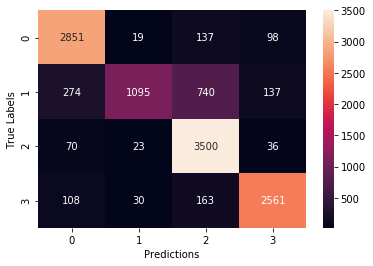

In [74]:
sns.heatmap(confusion_matrix(y_test, ypred_nb),fmt = 'd', annot = True)
plt.xlabel('Predictions')
plt.ylabel('True Labels')

### 5.2 Avaliação Individual para o Modelo SVM 

In [75]:
print('Accuracy SVM:', accuracy_score(y_test, ypred_svm))
print('Precision SVM:', precision_score(y_test, ypred_svm, average = 'macro' ))
print('Kappa Score SVM:', cohen_kappa_score(y_test, ypred_svm))

Accuracy SVM: 0.8919945955075156
Precision SVM: 0.8866480671066653
Kappa Score SVM: 0.8546391398068571


In [76]:
print(classification_report(y_test, ypred_svm))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      3105
           1       0.77      0.81      0.79      2246
           2       0.90      0.92      0.91      3629
           3       0.96      0.88      0.92      2862

    accuracy                           0.89     11842
   macro avg       0.89      0.88      0.89     11842
weighted avg       0.89      0.89      0.89     11842



Text(33.0, 0.5, 'True Labels')

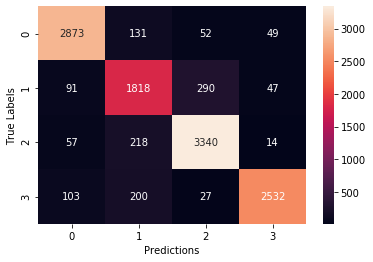

In [77]:
sns.heatmap(confusion_matrix(y_test, ypred_svm),fmt = 'd', annot = True)
plt.xlabel('Predictions')
plt.ylabel('True Labels')

### 5.3 Cross-Validation

### CV - Multinomial Naive Bayes

In [78]:
num_folds = 5
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

accuracy_list = []
precision_list = []
kappa_list = []

i = 1

for train_ix, val_ix in kfold.split(df[['clean_posts']], df['area']):
    print('Fold: {} / {}'.format(i, num_folds))
    
    X_train_fold = df.iloc[train_ix]
    y_train_fold = df['area'].iloc[train_ix]
    
    X_val_fold = df.iloc[val_ix]
    y_val_fold = df['area'].iloc[val_ix]
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range = (2,2))

    train_tfidf_fold = tfidf_vectorizer.fit_transform((X_train_fold['clean_posts'].apply(lambda x: np.str_(x)))) 
    val_tfidf_fold = tfidf_vectorizer.transform((X_val_fold['clean_posts'].apply(lambda x: np.str_(x))))
    
    model = MultinomialNB()
    model.fit(train_tfidf_fold, y_train_fold)
    
    y_pred_cv = model.predict(val_tfidf_fold)
    
    #metrics
    
    #Accuracy
    acc = accuracy_score(y_val_fold, y_pred_cv)
    accuracy_list.append(acc)
    
    #Precision
    prec = precision_score(y_val_fold, y_pred_cv, average = 'macro')
    precision_list.append(prec)
    
    #Kappa
    kappa = cohen_kappa_score(y_val_fold, y_pred_cv)
    kappa_list.append(kappa)
    
    
    i+=1
    
mnb_model = {
            'Model' : 'Multinomial NB',
            'Transformação': 'TF-IDF em bigramas',
            'Accuracy': '{:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)),
            'Precision': '{:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)),
            'Kappa Score': '{:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list))}

Fold: 1 / 5
Fold: 2 / 5
Fold: 3 / 5
Fold: 4 / 5
Fold: 5 / 5


In [79]:
# Salva o modelo de multinomial naive bayes sem tunning
pickle.dump(model, open("../Modelo Final/mnb_model.pkl", 'wb'))

In [80]:
print('Cross-Validation MNB Evaluation:')
print('Accuracy MNB: {:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
print('Precision MNB: {:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)))
print('Kappa Score MNB: {:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list)))

Cross-Validation MNB Evaluation:
Accuracy MNB: 0.857 +/- 0.003
Precision MNB: 0.878 +/- 0.003
Kappa Score MNB: 0.805 +/- 0.004


### CV - SVM c/ Kernel Linear

In [81]:
num_folds = 5
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

accuracy_list = []
precision_list = []
kappa_list = []

i = 1

for train_ix, val_ix in kfold.split(df['clean_posts'], df['area']):
    print('Fold: {} / {}'.format(i, num_folds))
    
    X_train_fold = df.iloc[train_ix]
    y_train_fold = df['area'].iloc[train_ix]
    
    X_val_fold = df.iloc[val_ix]
    y_val_fold = df['area'].iloc[val_ix]
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range = (2,2))

    train_tfidf_fold = tfidf_vectorizer.fit_transform((X_train_fold['clean_posts'].apply(lambda x: np.str_(x)))) 
    val_tfidf_fold = tfidf_vectorizer.transform((X_val_fold['clean_posts'].apply(lambda x: np.str_(x))))
    
    model = SVC(kernel='linear')
    model.fit(train_tfidf_fold, y_train_fold)
    
    y_pred_cv = model.predict(val_tfidf_fold)
    
    #metrics
    
    #Accuracy
    acc = accuracy_score(y_val_fold, y_pred_cv)
    accuracy_list.append(acc)
    
    #Precision
    prec = precision_score(y_val_fold, y_pred_cv, average = 'macro')
    precision_list.append(prec)
    
    #Kappa
    kappa = cohen_kappa_score(y_val_fold, y_pred_cv)
    kappa_list.append(kappa)
    
    
    i+=1
    
svm_model = {'Model' : 'SVM - Kernel Linear',
            'Transformação': 'TF-IDF em bigramas',
            'Accuracy': '{:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)),
            'Precision': '{:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)),
            'Kappa Score': '{:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list))}    

Fold: 1 / 5
Fold: 2 / 5
Fold: 3 / 5
Fold: 4 / 5
Fold: 5 / 5


In [82]:
# Salva o modelo de SVM sem tunning
pickle.dump(model, open("../Modelo Final/svm_model.pkl", 'wb'))

In [83]:
print('Cross-Validation SVM Evaluation:')
print('Accuracy SVM: {:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
print('Precision SVM: {:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)))
print('Kappa Score SVM: {:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list)))

Cross-Validation SVM Evaluation:
Accuracy SVM: 0.900 +/- 0.005
Precision SVM: 0.894 +/- 0.005
Kappa Score SVM: 0.865 +/- 0.006


### 6.0 Hyper-tunning do melhor modelo:

In [84]:
# Define os parâmetros a serem testados
param_grid = {'C': [0.1, 1, 10, 1000], 
              'gamma': [1, 0.01, 0.001],
              'kernel': ['linear']} 

In [85]:
# Utilização do Grid Search como algoritmo de tunning
grid = GridSearchCV(SVC(), param_grid, scoring = 'accuracy', refit = True, return_train_score=True, verbose = 3)
  
# Fit do modelo 
grid.fit(train_tfidf, y_train)

# Melhores parâmetros encontrados
print(grid.best_params_)
  
# Modelo após o hyper-tunning
print(grid.best_estimator_)



Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..................C=0.1, gamma=1, kernel=linear; total time= 4.7min
[CV 2/5] END ..................C=0.1, gamma=1, kernel=linear; total time= 4.7min
[CV 3/5] END ..................C=0.1, gamma=1, kernel=linear; total time= 4.8min
[CV 4/5] END ..................C=0.1, gamma=1, kernel=linear; total time= 4.7min
[CV 5/5] END ..................C=0.1, gamma=1, kernel=linear; total time= 4.7min
[CV 1/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time= 4.7min
[CV 2/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time= 4.7min
[CV 3/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time= 4.7min
[CV 4/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time= 4.7min
[CV 5/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time= 4.7min
[CV 1/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time= 4.7min
[CV 2/5] END ..............C=0.1, gamma=0.001, k

In [86]:
# Cria um modelo utilizando os parâmetros encontrados
final_model = SVC(**grid.best_params_)
final_model.fit(train_tfidf, y_train)

SVC(C=1, gamma=1, kernel='linear')

In [87]:
# Salva o modelo de SVM após o tunning
pickle.dump(final_model, open("../Modelo Final/svm_final_model_tuned.pkl", 'wb'))

In [88]:
ypred_final = final_model.predict(test_tfidf)

In [89]:
print('Accuracy Final Model:', accuracy_score(y_test, ypred_final))
print('Precision Final Model:', precision_score(y_test, ypred_final, average = 'macro' ))
print('Kappa Score Final Model:', cohen_kappa_score(y_test, ypred_final))

Accuracy Final Model: 0.8919945955075156
Precision Final Model: 0.8866480671066653
Kappa Score Final Model: 0.8546391398068571


In [90]:
# Realiza a cross-validation após hyper-tunning 
num_folds = 5
kfold = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 42)

accuracy_list = []
precision_list = []
kappa_list = []

i = 1

for train_ix, val_ix in kfold.split(df['clean_posts'], df['area']):
    print('Fold: {} / {}'.format(i, num_folds))
    
    X_train_fold = df.iloc[train_ix]
    y_train_fold = df['area'].iloc[train_ix]
    
    X_val_fold = df.iloc[val_ix]
    y_val_fold = df['area'].iloc[val_ix]
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range = (2,2))

    train_tfidf_fold = tfidf_vectorizer.fit_transform((X_train_fold['clean_posts'].apply(lambda x: np.str_(x)))) 
    val_tfidf_fold = tfidf_vectorizer.transform((X_val_fold['clean_posts'].apply(lambda x: np.str_(x))))
    
    model = SVC(C = 1, gamma = 1, kernel='linear')
    model.fit(train_tfidf_fold, y_train_fold)
    
    y_pred_cv = model.predict(val_tfidf_fold)
    
    #metrics
    
    #Accuracy
    acc = accuracy_score(y_val_fold, y_pred_cv)
    accuracy_list.append(acc)
    
    #Precision
    prec = precision_score(y_val_fold, y_pred_cv, average = 'macro')
    precision_list.append(prec)
    
    #Kappa
    kappa = cohen_kappa_score(y_val_fold, y_pred_cv)
    kappa_list.append(kappa)
    
    
    i+=1
    
svm_model_tunned = {'Model' : 'SVM - Kernel Linear após Tunning',
            'Transformação': 'TF-IDF em bigramas',
            'Accuracy': '{:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)),
            'Precision': '{:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)),
            'Kappa Score': '{:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list))}    

Fold: 1 / 5
Fold: 2 / 5
Fold: 3 / 5
Fold: 4 / 5
Fold: 5 / 5


In [91]:
print('Cross-Validation SVM after tunning Evaluation:')
print('Accuracy SVM: {:.3f} +/- {:.3f}'.format(np.mean(accuracy_list),np.std(accuracy_list)))
print('Precision SVM: {:.3f} +/- {:.3f}'.format(np.mean(precision_list),np.std(precision_list)))
print('Kappa Score SVM: {:.3f} +/- {:.3f}'.format(np.mean(kappa_list),np.std(kappa_list)))

Cross-Validation SVM after tunning Evaluation:
Accuracy SVM: 0.900 +/- 0.005
Precision SVM: 0.894 +/- 0.005
Kappa Score SVM: 0.865 +/- 0.006


## 7.0 Comparativo dos modelos testados:


In [92]:
comp_models = [mnb_model, svm_model, svm_model_tunned]

In [93]:
pd.DataFrame(comp_models, index=np.arange(0, len(comp_models)))

,Model,Transformação,Accuracy,Precision,Kappa Score
0,Multinomial NB,TF-IDF em bigramas,0.857 +/- 0.003,0.878 +/- 0.003,0.805 +/- 0.004
1,SVM - Kernel Linear,TF-IDF em bigramas,0.900 +/- 0.005,0.894 +/- 0.005,0.865 +/- 0.006
2,SVM - Kernel Linear após Tunning,TF-IDF em bigramas,0.900 +/- 0.005,0.894 +/- 0.005,0.865 +/- 0.006


## 8.0 Prevendo novos dados:

In [94]:
model = pickle.load(open("../Modelo Final/svm_final_model_tuned.pkl", 'rb'))
tfidf_vectorizer = pickle.load(open("../Modelo Final/tfidf_vect.pkl", 'rb'))

In [95]:
pergunta1 = 'Hugo, corretor de imóveis, recebe oferta de contrato, por prazo indeterminado, para intermediar a realização de negócios sobre novo empreendimento imobiliário, cujo lançamento ocorrerá em data próxima, obtendo as seguintes informações: (i) as características gerais do empreendimento, com a descrição da planta, da área e do valor de cada unidade autônoma projetada, em condomínio edilício; (ii) o valor oferecido em remuneração pelos serviços de corretagem correspondente a 4% sobre o valor da venda.     * A responsabilidade por dano ambiental é objetiva e orientada pela teoria do risco integral, introduzindo o nexo de causalidade no próprio ato ensejador do dano. Entusiasmado, Hugo entra em contato com diversos clientes (potenciais compradores), a fim de mediar a celebração de compromissos de compra e venda com o dono do negócio. Nesse ínterim, consegue marcar uma reunião entre o incorporador (dono do negócio) e seu melhor cliente, sócio de uma grande rede de farmácias, pretendendo adquirir a loja principal do empreendimento. Após a reunião, em que as partes se mostraram interessadas em prosseguir com as negociações, nenhum dos futuros contratantes tornou a responder ao corretor, que não mais atuou nesse empreendimento, ante a sua dispensa. Soube, meses depois, que o negócio havia sido fechado entre o incorporador e o comprador, em negociação direta, ao valor de R$ 5.000.000,00 (cinco milhões de reais).  '
pergunta2 = 'A Administração Pública é autorizada a praticar todos os atos que a lei não veda?  * A administração direta é o conjunto de órgãos que integram as pessoas federativas que realizam a prestação de serviços de  forma  direta  pelos  próprios  entes  políticos  da Administração?'

#Load pickles 
model = pickle.load(open("../Modelo Final/svm_final_model_tuned.pkl", 'rb'))
tfidf_vectorizer = pickle.load(open("../Modelo Final/tfidf_vect.pkl", 'rb'))
le_enc = pickle.load(open("../Modelo Final/class_encoding.pkl", 'rb'))

# Pipeline
clean_data = run_clean_pipeline(pergunta2)
clean_data_transf = tfidf_vectorizer.transform([clean_data])

# Final model
class_pred = model.predict(clean_data_transf)

print("Baseado na sua pergunta, nosso sistema recomenda você procurar um advogado especializado na área {}.".format(le_enc.classes_[class_pred[0]]))

Baseado na sua pergunta, nosso sistema recomenda você procurar um advogado especializado na área Administrativo.


## Sugestões de Melhorias:

- ~~Utilização de SVM c/ Linear Kernel~~
- ~~Utilização de Bigramas antes da transformação TF-IDF com o MultinomialNB ou o SVM LK~~
- Utilização de Redes Neurais - LSTM -> **Acredito que a acurácia já alcançou valores muito satisfatórios, então não será necessário.**
- SMOTE para um melhor balanceamento das classes -> **Alcançamos um balanceamento ok dos dados apenas removendo a classe Família**
- Análise da Nuvem de palavras pra cada classe, a fim de identificar quais termos aparecem com mais frequência dependendo da classe -> **Fazer isso é importante**
- ~~Redução de dimensionalidade~~ -> **cai muito a precisão**